In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [74]:
#!pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting un

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-07-05 13:44:52.850213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 13:44:52.850369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 13:44:53.008616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATA_INPUT_PATH = "/kaggle/input/iam-handwriting-word-database"

images_path = []
labels = []

def preprocess_dataset():
    characters = set()
    max_len = 0
    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()

        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()

            # Continue with the rest of the code
            word_id = parts[0]

            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
            image_filename = f"{word_id}.png"
            image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
            if os.path.isfile(image_path) and os.path.getsize(image_path):

                images_path.append(image_path)

                # Extract labels
                label = parts[-1].strip()
                for char in label:
                    characters.add(char)

                max_len = max(max_len, len(label))
                labels.append(label)

    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    # Mapping characters to integers.
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = tf.keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return characters, char_to_num, num_to_char, max_len
    
characters, char_to_num, num_to_char, max_len = preprocess_dataset()

characters:  ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  19


In [4]:
print(len(labels))

44563


In [4]:
IMAGE_SIZE = (32,128)
PADDING_TOKEN = 99
BATCH_SIZE=32

In [5]:
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(
        label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]],
                   constant_values=PADDING_TOKEN)
    return label
def process(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image,  channels=1)
    image=tf.image.resize(image, IMAGE_SIZE)
    image = tf.transpose(image, perm=[1,0, 2])
    image = tf.cast(image, tf.float32) / 255.0
    label = vectorize_label(label)  # if additional vectorization is needed
    return {"image": image, "label": label}
def prepare_dataset(images_files, images_labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_files, images_labels))
    dataset = dataset.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


In [6]:
def split_dataset():
    # Split the data into training, validation, and test sets using train_test_split
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_path, labels, test_size=0.2, random_state=42
    )

    # Further split the test set into validation and final test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )

    train_set = prepare_dataset(train_images, train_labels)
    val_set = prepare_dataset(val_images, val_labels)
    test_set = prepare_dataset(test_images, test_labels)
    print(len(train_images))
    print(len(train_labels))
    print(len(test_labels))
    print("Train df: \n",train_set)
    print("Test df: \n",test_set)
    print("Val df: \n",val_set)
    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset()

35650
35650
4457
Train df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 128, 32, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
Test df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 128, 32, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
Val df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 128, 32, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


tf.Tensor(
[[68 55 53 51 66 70 71 68 55 99 99 99 99 99 99 99 99 99 99]
 [59 64 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [69 51 62 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [64 55 73 69 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [71 69 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [72 51 68 59 55 70 75 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 65 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [56 65 68 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [55 68 68 65 68 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [51 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [75 65 71 64 57 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [65 56 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [37 75 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [56 59 68 63 62 75 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 58 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 58 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 58 55 63 99 99 99 99 99 

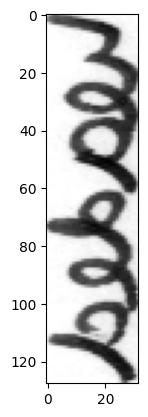

In [26]:
batch = next(iter(test_set.take(1)))
image = batch['image'][:]  # Assuming batch['image'] is a batch of images, accessing the first image
labl=batch['label']
# Now you can print or process the single image
print(labl)
text_label = num_to_char(labl)
text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
text_label = text_label.replace("[UNK]", " ").strip()
print(text_label)
#image=tf.squeeze(image)
for im in image:
    print(im.shape)
    plt.imshow(im, cmap='binary_r')



32
(32, 128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)


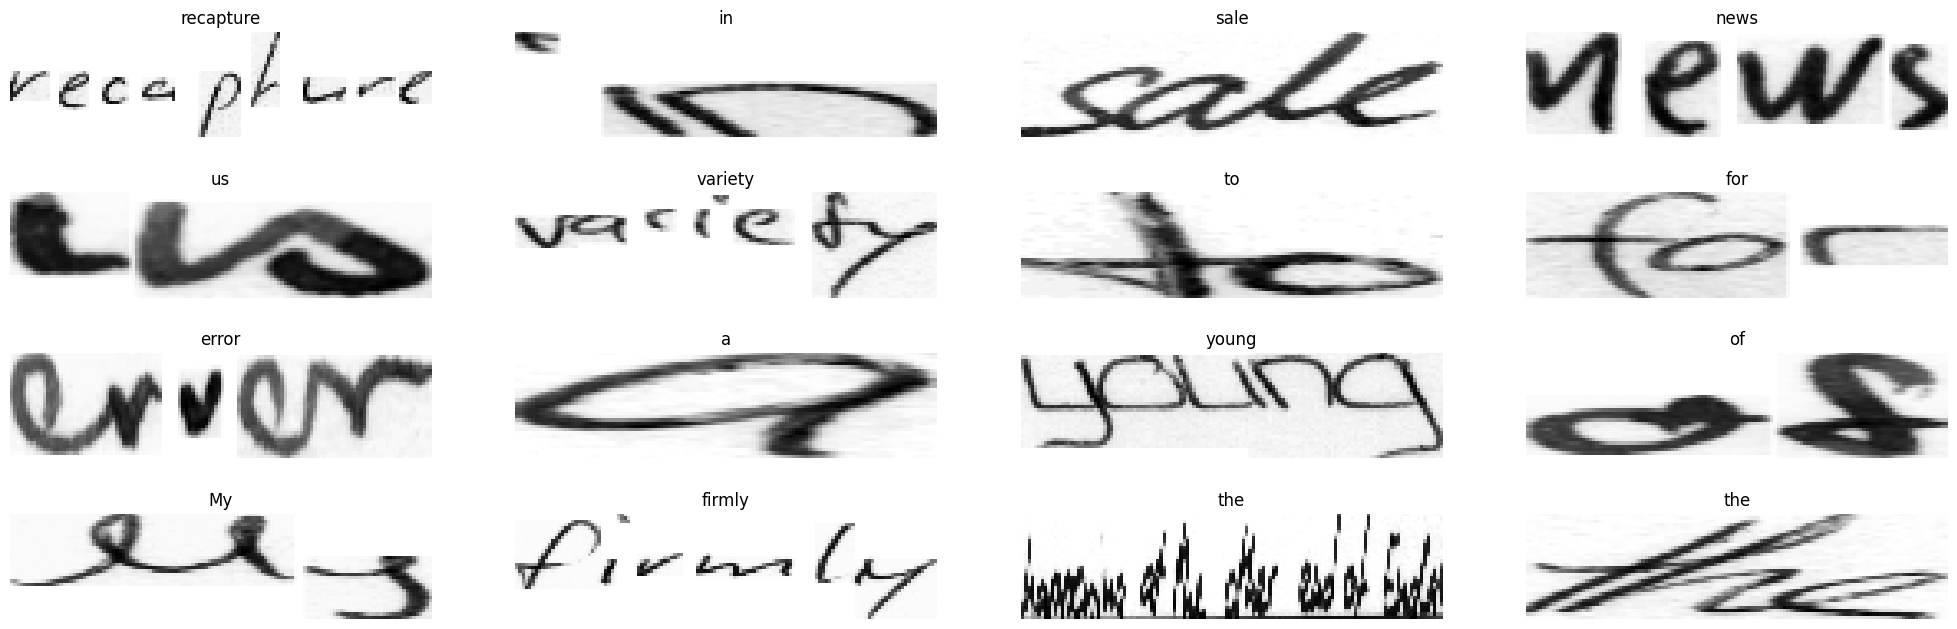

In [8]:
FIGSIZE=(25, 8)
GRID=[4,4]
plt.figure(figsize=FIGSIZE)
n_rows, n_cols = GRID
    
    # Loading Data 
data = next(iter(test_set))
images, img_labels = data['image'], data['label']
print(len(img_labels))
print(images.shape)

    
    # Iterate over the data 
for index,(image, label) in enumerate(zip(images, img_labels)):
        if index==(n_rows*n_cols):
            break
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        print(image.shape)
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]),cmap='binary_r')
        plt.axis('off')
        plt.title(text_label)

In [9]:
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

In [10]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, label_len, input_len) 

        self.add_loss(loss)

        return y_hat

In [13]:
input_images = Input(shape=(128,32, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3


conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((128//4), (32//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+2, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output)

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [81]:
def build_model():
    input_img = tf.keras.layers.Input(
        shape=(128, 32, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((128 // 4), (32 // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(
        inputs=[input_img,labels], outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    model.summary()
    return model
    
model = build_model()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 16,    │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 8, 64) │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 32, 512)   │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32, 64)    │     32,832 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 64)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 32, 256)   │    197,632 │ dropout_8[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 32, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 79)    │     10,191 │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 79)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,823 (1.62 MB)

 Trainable params: 423,823 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

0


In [12]:
 pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [35]:
from tensorflow import keras
from tensorflow.keras import layers
from jiwer import wer
from IPython import display
from tensorflow.keras.callbacks import Callback



In [37]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.6 MB/s eta 0:00:0000:01


In [38]:
from Levenshtein import distance as lev_distance

In [56]:
model.input[0]

<KerasTensor shape=(None, 128, 32, 1), dtype=float32, sparse=None, name=image>

In [135]:
def wer(reference, hypothesis):
  """
  Calculates the Word Error Rate (WER) between a reference sequence and a hypothesis sequence.

  Args:
      reference: A string representing the ground truth text (including punctuation).
      hypothesis: A string representing the predicted text (including punctuation).

  Returns:
      A float value between 0 and 1 representing the WER.
  """
  # Ensure reference and hypothesis are lowercase for case-insensitive comparison
  reference = reference.lower()
  hypothesis = hypothesis.lower()

  # Add 1 to avoid division by zero
  n = len(reference) + 1
  m = len(hypothesis) + 1

  # Create a distance matrix
  d = np.zeros((n, m))

  # Initialize the first row and column with insertion costs
  for i in range(1, n):
    d[i, 0] = i
  for j in range(1, m):
    d[0, j] = j

  # Fill the distance matrix using Levenshtein distance algorithm
  for i in range(1, n):
    for j in range(1, m):
      if reference[i - 1] == hypothesis[j - 1]:
        cost = 0
      else:
        cost = 1
      d[i, j] = min(d[i - 1, j] + 1,  # Insertion
                    d[i, j - 1] + 1,  # Deletion
                    d[i - 1, j - 1] + cost)  # Substitution

  # WER is the normalized Levenshtein distance
  print(d[n-1,m-1])
  wer = d[n - 1, m - 1] / max(len(reference), len(hypothesis))
  return wer

# Example usage
target_text = "thner"
pred_text = "tnertrr"  # Introduce some errors for demonstration

wer_value = wer(target_text, pred_text)
print(f"WER: {wer_value:.4f}")

4.0
WER: 0.5714


In [136]:
t="thner"
s="tnertrr"
print(lev_distance(' '.join(t), ' '.join(s)))

7


In [105]:
def wer(target_text, pred_text):
    """
    Calculate the Word Error Rate (WER).
    
    Parameters:
    target_text (str): The ground truth text.
    pred_text (str): The predicted text.
    
    Returns:
    float: The WER value.
    """
    # Split the texts into words
    target_words = target_text.split()
    pred_words = pred_text.split()
    
    # Calculate the Levenshtein distance between the word lists
    edit_distance = lev_distance(' '.join(target_words), ' '.join(pred_words))
    
    # Calculate WER
    wer_value = edit_distance / len(target_words)
    
    return wer_value
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    #for result in results:
     #   result = tf.gather(result, tf.where(tf.math.not_equal(result, -1)))
      #  result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
      #  output_text.append(result)
    for result in results:
         text_label = num_to_char(result)
         text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
         text_label = text_label.replace("[UNK]", " ").strip()
         output_text.append(text_label)
        
    return output_text


# A callback class to output a few transcriptions during training
class WerCallback(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        wer_values = []
        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            #input_l = np.ones(labels.shape[0]) * labels.shape[1]
            
    # Use greedy search. For complex tasks, you can use beam search
            #res = tf.keras.backend.ctc_decode(labels, input_length=input_l, greedy=True)[0][0]
            #print(res)
            
            predictions = self.prediction_model.predict(
                self.validation_images[i])
            
            predictions = decode_batch_predictions(predictions)
            predictions.extend(predictions)
            print(predictions)
            
            for label in labels:
                text_label = num_to_char(label)
                text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
                text_label = text_label.replace("[UNK]", " ").strip()
                targets.append(text_label)
            #print(predictions)
            for pred_text, target_text in zip(predictions, targets):
                #print(len(pred_text),len(target_text))
                wer_value = wer(target_text, pred_text)
                wer_values.append(wer_value)
            
            
                
        avg_wer = np.mean(wer_values)
        print(f"Epoch {epoch+1}: Average WER: {avg_wer:.4f}")
            #print(targets)
         

In [89]:
model.get_layer(name="image").input

[]

0


In [106]:
output_layer = model.get_layer(name="dense2").output
desired_input_index = 0  # Change this to 1 if the desired input comes from the second branch
input_tensors = [model.inputs[i] for i in range(len(model.inputs))]
#output_tensor = model.layers[concat_layer_index].inputs[desired_input_index]
print(desired_input_index)
#desired_branch_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=model.get_layer("dense2").output )


# Create a new model with the specific input and output layers
prediction_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=output_layer)

0


In [ ]:
validation_images = []
validation_labels = []

for batch in val_set:
        validation_images.append(batch["image"])
        validation_labels.append(batch["label"])



WER_callback = WerCallback(
        prediction_model,  validation_images, validation_labels)
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
history=model.fit(train_set,epochs=15,validation_data=val_set,callbacks=[WER_callback, early_stopping])


#WER_callback.on_epoch_end(1)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/steps/step - loss: i
['a', 'me', 'th', ',', 'ae', 'of', 'th', 'o', 'p', 'wo', 'p', 'o', 'a', 'th', ',', 'th', 'p', 'wa', 'wo', 'wa', 'th', 'p', 'wa', 'a', 'to', 'po', 'a', 'of', 'a', 'fo', 'th', 'wa', 'a', 'me', 'th', ',', 'ae', 'of', 'th', 'o', 'p', 'wo', 'p', 'o', 'a', 'th', ',', 'th', 'p', 'wa', 'wo', 'wa', 'th', 'p', 'wa', 'a', 'to', 'po', 'a', 'of', 'a', 'fo', 'th', 'wa']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
['th', 'of', '.', 'wa', 'wh', 'p', 'p', ',', 't', 'wa', ',', ',', 'th', 'pe', 't', 't', 't', ',', '.', 'o', 'wh', 'a', 'po', 's', 'wo', 'a', 'wa', 'p', 'th', 'p', 'wo', 'o', 'th', 'of', '.', 'wa', 'wh', 'p', 'p', ',', 't', 'wa', ',', ',', 'th', 'pe', 't', 't', 't', ',', '.', 'o', 'wh', 'a', 'po', 's', 'wo', 'a', 'wa', 'p', 'th', 'p', 'wo', 'o']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
['wa', 'wo', 'th', ',', 'th', '.', 'of', 'o', ',', 'wa', 'w', 'ao', ',', 'i', 't', ',', 'a', 'pe', 'wo', 'wa', 'pe', 'f', 'ta', 't', '.', 'th', 'th', 't

In [72]:
import sys
print(sys.version)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [75]:
!pip list

Package                                  Version
---------------------------------------- ------------------
absl-py                                  1.4.0
accelerate                               0.30.1
access                                   1.1.9
affine                                   2.4.0
aiobotocore                              2.13.0
aiofiles                                 22.1.0
aiohttp                                  3.9.1
aioitertools                             0.11.0
aiorwlock                                1.3.0
aiosignal                                1.3.1
aiosqlite                                0.19.0
albumentations                           1.4.0
alembic                                  1.13.1
altair                                   5.3.0
annotated-types                          0.6.0
annoy                                    1.17.3
anyio                                    4.2.0
apache-beam                              2.46.0
aplus                                

In [114]:
for batch in test_set.take(6):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(len(batch_images))
print(len(test_set))


32
32
32
32
32
32
140


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
['coiesy', 'in', 'see', 'woes', 'te', 'way', 'to', 'for', 'wor', 'a', 'poy', 'of', 'thy', 'tely', 'maese', 'the', 'thesd', 'isd', 'Goes', 'Coldhe', 'not', 'hisd', 'thsd', 'of', 'poly', 'the', 'ofy', '"', 'the', 'thed', 'at', 'meesdhe']
in in
to to
for for
a a
of of
the the
not not
of of
the the
" "
the the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
['diions', 'Phe', '.', 'petsy', 'ths', 'ofy', 'aesy', 'sntieshe', 'the', 'a', 'to', '"', 'bengy', 'peny', 'in', ',', 'metdh', '.', 'wedhe', 'ba', 'aodh', 'tay', 'a', 'toe', 'tegesy', 'ti', 'badh', 'fy', 'hath', 'wi', 'ad', 'thed']
. .
the the
a a
" "
in in
, ,
. .
a a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
['hadd', 'shdh', 'ay', 'felhy', 'ay', ',', 'ted', '.', 'to', 'poy', 'tyy', ',', 'aty', 'predtdy', 'whdth', '"', 'wos', ',', 'the', 'thed', 'wee', 'ofy', 'agdy', 'we', 'thtdh', 'wh', 'is', 'adh', ',', 'the', 'wase', 'the']
, ,
. .
to to
, ,
" "
, ,
is is
, ,
the the
the the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/st

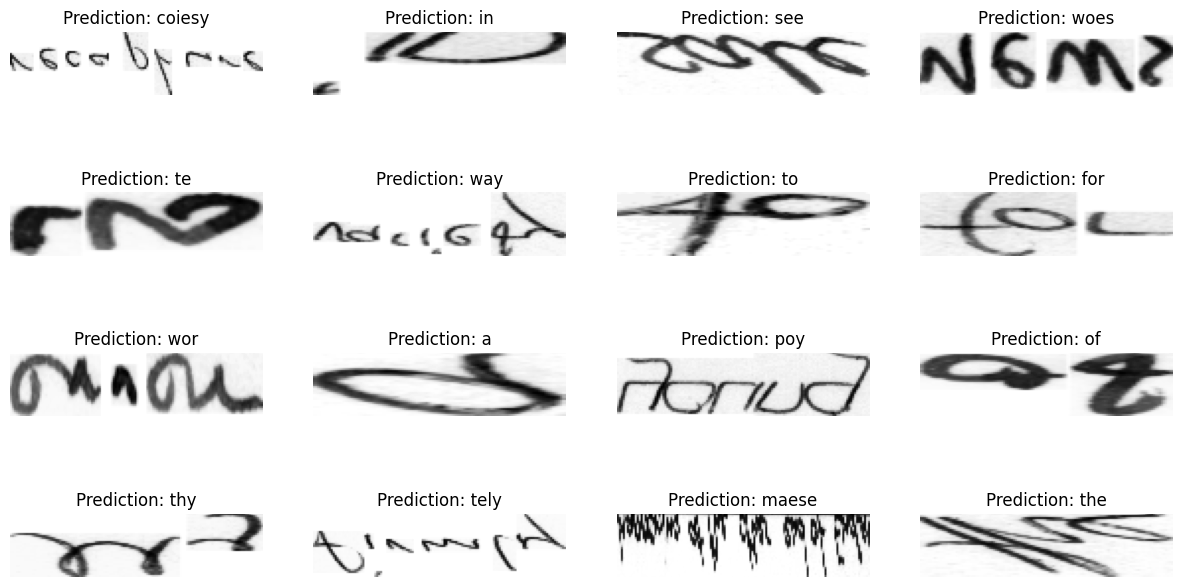

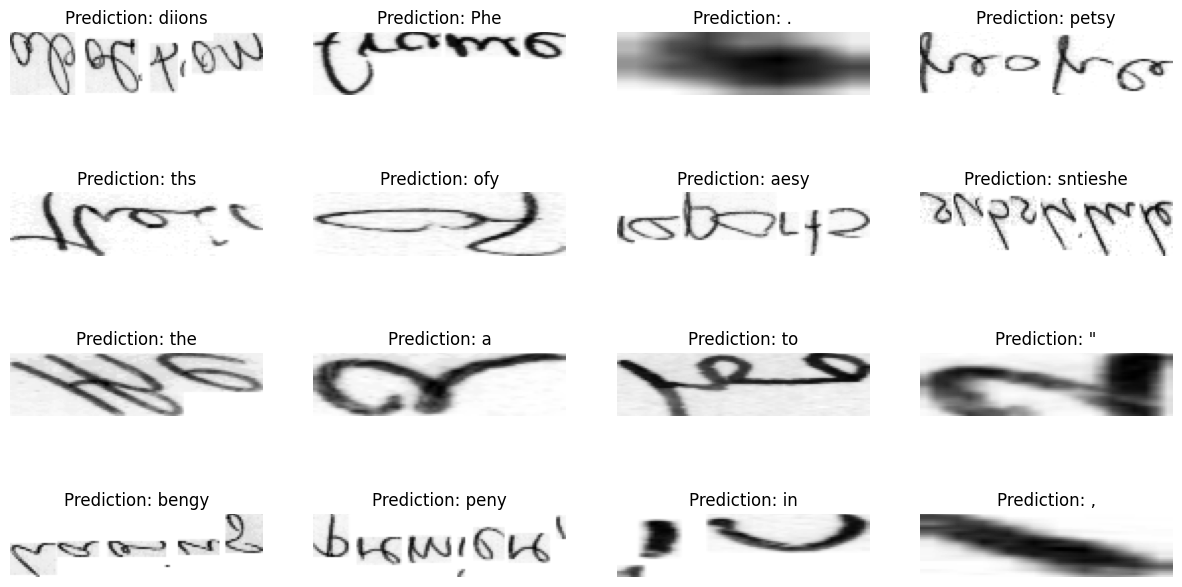

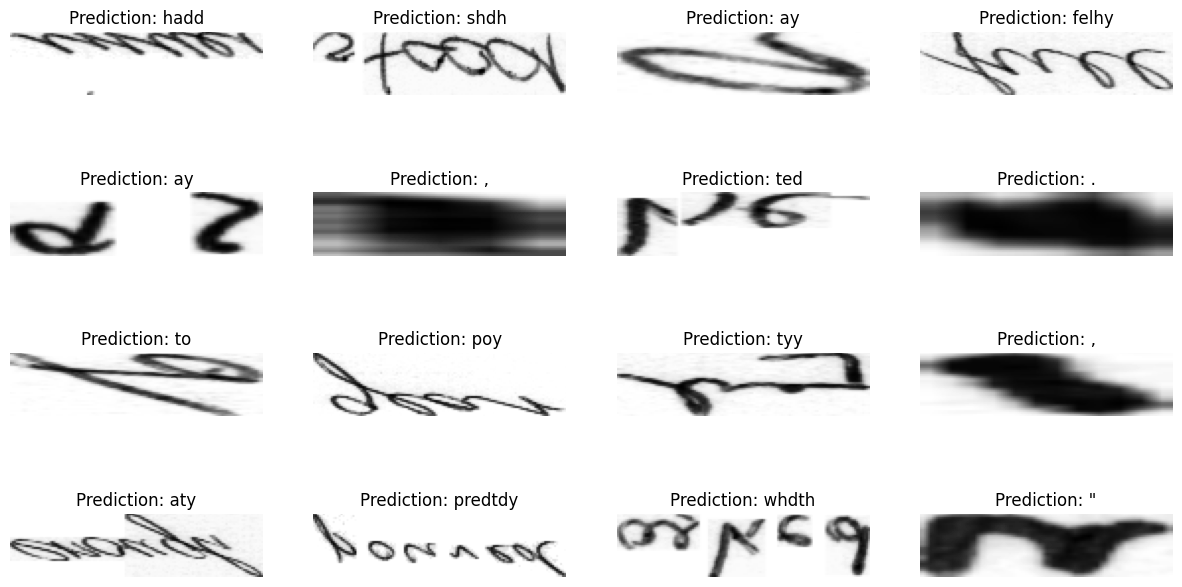

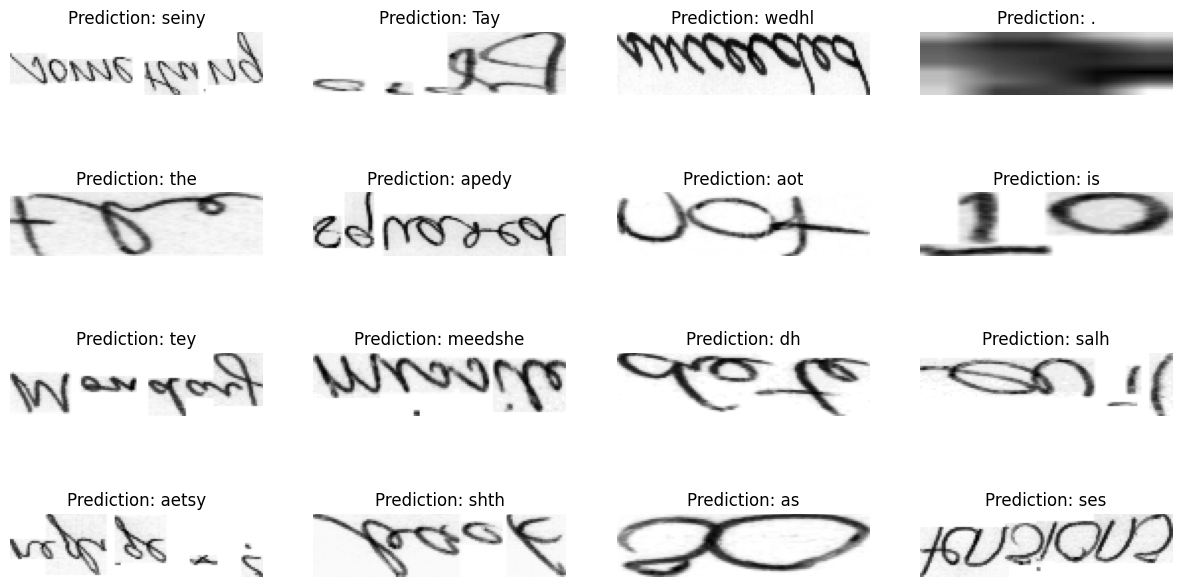

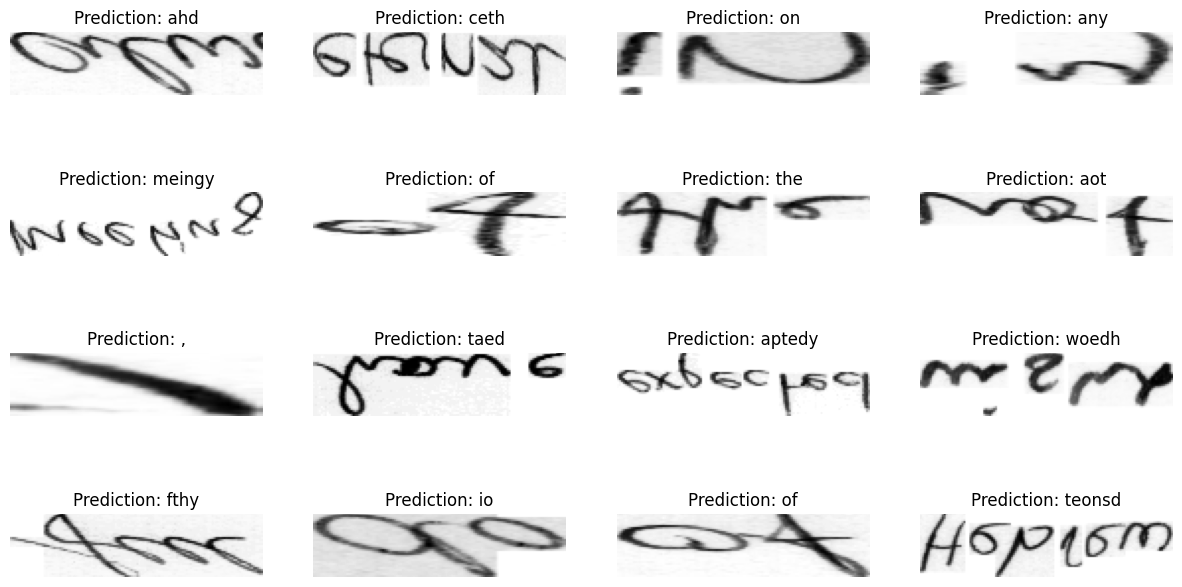

43
160
Correct words predicted      : 26.88%


In [115]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    

    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        
    print(output_text)    
    return output_text

correct=0
total=0
#  Let's check results on some test samples.
for batch in test_set.take(5):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
   
    for k in range(len(batch_images)):
        total=total+1
        lab= batch_labels[k]
        text_label1 = num_to_char(lab)
        text_label1 = tf.strings.reduce_join(text_label1).numpy().decode('UTF-8')
        text_label1 = text_label1.replace("[UNK]", " ").strip()
        if pred_texts[k]==text_label1:
            correct+=1
            print(pred_texts[k],text_label1)
        
    for i in range(16):
        img = batch_images[i]
        lb= batch_labels[i]
        text_label = num_to_char(lb)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
         
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        #print(text_label)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()
print(correct)
print(total)
print('Correct words predicted      : %.2f%%' %(correct*100/total))

In [87]:
for layer in model.layers:
    print(layer.name)
input_layer = model.get_layer(name="image").input
output_layer = model.get_layer(name="dense2").output
desired_input_index = 0  # Change this to 1 if the desired input comes from the second branch
input_tensors = [model.inputs[i] for i in range(len(model.inputs))]
#output_tensor = model.layers[concat_layer_index].inputs[desired_input_index]
print(desired_input_index)
#desired_branch_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=model.get_layer("dense2").output )


# Create a new model with the specific input and output layers
prediction_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=output_layer)

image
conv2d_16
max_pooling2d_16
conv2d_17
max_pooling2d_17
reshape_8
dense_8
dropout_8
bidirectional_16
bidirectional_17
label
dense2
ctc_loss
0


<KerasTensor shape=(None, 128, 32, 1), dtype=float32, sparse=None, name=image>


5
tf.Tensor(
[[69 51 75 69 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [71 64 66 68 55 53 55 54 55 64 70 55 54 99 99 99 99 99 99]
 [70 58 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [ 2 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [35 55 64 64 55 70 58 99 99 99 99 99 99 99 99 99 99 99 99]
 [59 64 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 65 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [65 56 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [53 65 63 66 51 68 59 69 65 64 69 99 99 99 99 99 99 99 99]
 [62 65 51 64  9 73 65 68 54 99 99 99 99 99 99 99 99 99 99]
 [51 57 68 55 55 54 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [51 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [69 65 68 70 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [32 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [ 8 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [70 58 55 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
 [66 55 68 58 51 66 69 99 9